In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from pathlib import Path
import json
import re

import torch
from torch import Tensor
import torch.optim as optim
from torch.utils.data import Dataset
from torch import nn
from torch import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import image as mpl_image
from typing import Type, Any, Callable, Union, List, Optional

from hmmlearn import hmm


In [3]:
from centrilyze import CentrioleImageFiles, ImageDataset, CentrioleImageModel, HMM, constants, image_transform, target_transform, annotate, nest_annotation_keys, get_sequence_matrix, get_transition_count_matrix, get_transition_rate_matrix, get_confusion_matrix, reannotate, save_all_state_figs

# Settings

In [4]:
test_folder = Path("/nic/data/test/col_02-20220318T142333Z-001")
model_file = Path("/nic/models/model_resnet_18_high_low_affine_149.pyt")
annotations_file = Path("/nic/annotations.json")
sequences_file = Path("/nic/sequences.npy")
emission_matrix_path = Path("/nic/emission_matrix.npy")
emission_matrix_path_three_classes = Path("/nic/emission_matrix_three_classes.npy")
output_dir = Path("/nic/output/col_02")

n_iter=1000
batch_size = 4

# Data Loading

In [5]:
centriole_image_files = CentrioleImageFiles.from_unannotated_images(test_folder)

In [6]:
# centriole_image_files.images

In [7]:
image_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.Normalize(0.0, 1.0, inplace=False),
    ]
)

In [8]:
testset = ImageDataset.from_centriole_image_files(
    centriole_image_files, 
    image_transform, 
    target_transform,
)

In [9]:
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, 
                                         drop_last=False
                                        )

[{'image': tensor([[[0.0137, 0.0128, 0.0201, 0.0201, 0.0128, 0.0084, 0.0084, 0.0405,
            0.0582, 0.0318, 0.0128, 0.0128, 0.0297, 0.0318, 0.0695, 0.0695,
            0.0405, 0.0233, 0.0043, 0.0180, 0.0180, 0.0201, 0.0362, 0.0362,
            0.0233, 0.0027, 0.0018, 0.0043],
           [0.0075, 0.0075, 0.0137, 0.0137, 0.0201, 0.0318, 0.0254, 0.0233,
            0.0254, 0.0075, 0.0075, 0.0013, 0.0430, 0.0738, 0.0819, 0.0582,
            0.0201, 0.0084, 0.0043, 0.0018, 0.0075, 0.0128, 0.0233, 0.0695,
            0.0474, 0.0043, 0.0013, 0.0075],
           [0.0137, 0.0180, 0.0180, 0.0137, 0.0201, 0.0233, 0.0297, 0.0137,
            0.0043, 0.0075, 0.0043, 0.0075, 0.0254, 0.0362, 0.0362, 0.0254,
            0.0233, 0.0137, 0.0137, 0.0018, 0.0013, 0.0043, 0.0084, 0.0254,
            0.0201, 0.0043, 0.0128, 0.0297],
           [0.0518, 0.0405, 0.0233, 0.0084, 0.0137, 0.0233, 0.0362, 0.0297,
            0.0027, 0.0027, 0.0075, 0.0233, 0.0582, 0.0405, 0.0430, 0.0254,
            0.0084, 

# Define the model

In [11]:
model = CentrioleImageModel()

# Load the trained model params

In [12]:
image_model = CentrioleImageModel()


In [13]:
image_model.load_state_dict(model_file, map_location=torch.device("cpu"))


# Annotate the data with the model

In [14]:
annotations = annotate(image_model, testloader)

{('video[C1-MAX_211120_ngasl_jupmch_col_03_20MLE.vsi.tif]', 0, 0): {'true': 5,
  'assigned': 3},
 ('video[C1-MAX_211120_ngasl_jupmch_col_03_20MLE.vsi.tif]', 0, 10): {'true': 5,
  'assigned': 5},
 ('video[C1-MAX_211120_ngasl_jupmch_col_03_20MLE.vsi.tif]', 0, 11): {'true': 5,
  'assigned': 5},
 ('video[C1-MAX_211120_ngasl_jupmch_col_03_20MLE.vsi.tif]', 0, 12): {'true': 5,
  'assigned': 3},
 ('video[C1-MAX_211120_ngasl_jupmch_col_03_20MLE.vsi.tif]', 0, 13): {'true': 5,
  'assigned': 5},
 ('video[C1-MAX_211120_ngasl_jupmch_col_03_20MLE.vsi.tif]', 0, 14): {'true': 5,
  'assigned': 3},
 ('video[C1-MAX_211120_ngasl_jupmch_col_03_20MLE.vsi.tif]', 0, 1): {'true': 5,
  'assigned': 3},
 ('video[C1-MAX_211120_ngasl_jupmch_col_03_20MLE.vsi.tif]', 0, 2): {'true': 5,
  'assigned': 3},
 ('video[C1-MAX_211120_ngasl_jupmch_col_03_20MLE.vsi.tif]', 0, 3): {'true': 5,
  'assigned': 3},
 ('video[C1-MAX_211120_ngasl_jupmch_col_03_20MLE.vsi.tif]', 0, 4): {'true': 5,
  'assigned': 3},
 ('video[C1-MAX_211120_ng

In [16]:
nested_annotations = nest_annotation_keys(annotations)

# Output the confusion matrix

In [17]:
confusion_matrix_test_table = get_confusion_matrix(annotations)

In [18]:
confusion_matrix_test_table

,Not_Oriented,Oriented,Precieved_Not_Oriented,Precieved_Oriented,Slanted,Unidentified,No_sample
Not_Oriented,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Oriented,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Precieved_Not_Oriented,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Precieved_Oriented,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Slanted,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Unidentified,0.0,10.0,74.0,98.0,45.0,181.0,0.0
No_sample,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Get the Sequences

In [19]:
sequence_matrix = get_sequence_matrix(nested_annotations, list(range(20)), 7)

In [20]:
sequence_matrix.shape

(29, 20)

# All classes: Get the naive transition counts and rates

In [21]:
transition_count_matrix = get_transition_count_matrix(sequence_matrix, 7)

In [22]:
np.set_printoptions(precision=3, suppress=True)


In [23]:
naive_transition_table = pd.DataFrame(
data=transition_count_matrix,
index=list(constants.classes.keys()),
columns=list(constants.classes.keys()))
naive_transition_table

,Not_Oriented,Oriented,Precieved_Not_Oriented,Precieved_Oriented,Slanted,Unidentified,No_sample
Not_Oriented,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Oriented,0.0,4.0,0.0,6.0,0.0,0.0,0.0
Precieved_Not_Oriented,0.0,0.0,36.0,4.0,16.0,17.0,1.0
Precieved_Oriented,0.0,4.0,3.0,41.0,7.0,35.0,8.0
Slanted,0.0,0.0,14.0,10.0,12.0,9.0,0.0
Unidentified,0.0,0.0,9.0,30.0,7.0,115.0,20.0
No_sample,0.0,2.0,12.0,7.0,3.0,5.0,143.0


In [24]:
transition_rate_matrix = get_transition_rate_matrix(transition_count_matrix)

c:\nic\centrilyze\centrilyze\hmm.py:108: RuntimeWarning: invalid value encountered in true_divide
  naive_transition_matrix = transition_count_matrix / np.sum(transition_count_matrix, axis=1).reshape((-1, 1))


In [25]:
classes = {
    "Not_Oriented": 0, 
    "Oriented": 1, 
    "Precieved_Not_Oriented": 2, 
    "Precieved_Oriented": 3, 
    "Slanted": 4, 
    "Unidentified": 5, 
    "No_sample": 6,
}

naive_transition_table = pd.DataFrame(
data=transition_rate_matrix,
index=list(classes.keys()),
columns=list(classes.keys()))
naive_transition_table

,Not_Oriented,Oriented,Precieved_Not_Oriented,Precieved_Oriented,Slanted,Unidentified,No_sample
Not_Oriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Oriented,0.0,0.400000,0.000000,0.600000,0.000000,0.000000,0.000000
Precieved_Not_Oriented,0.0,0.000000,0.486486,0.054054,0.216216,0.229730,0.013514
Precieved_Oriented,0.0,0.040816,0.030612,0.418367,0.071429,0.357143,0.081633
Slanted,0.0,0.000000,0.311111,0.222222,0.266667,0.200000,0.000000
Unidentified,0.0,0.000000,0.049724,0.165746,0.038674,0.635359,0.110497
No_sample,0.0,0.011628,0.069767,0.040698,0.017442,0.029070,0.831395


# Three classes: Get the counts and transition rates

In [26]:
reannotations = reannotate(nested_annotations, constants.annotation_mapping)

In [27]:
sequence_3_classes_matrix = get_sequence_matrix(reannotations, list(range(20)), 5)

In [28]:
sequence_3_classes_matrix

array([[1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 3, 1, 4, 4, 4, 4, 4],
       [0, 0, 0, 0, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 4, 4, 4, 4, 4],
       [2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4],
       [1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 4, 4, 4, 4, 4],
       [1, 0, 1, 3, 1, 2, 1, 3, 3, 1, 3, 2, 3, 3, 3, 4, 4, 4, 4, 4],
       [1, 2, 0, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 4, 4, 4, 4, 4],
       [3, 3, 0, 0, 3, 0, 2, 0, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 3, 4, 4, 4, 4, 4],
       [0, 2, 2, 2, 3, 0, 0, 2, 0, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4],
       [1, 1, 3, 1, 2, 0, 0, 2, 0, 3, 0, 3, 3, 3, 3, 4, 4, 4, 4, 4],
       [1, 1, 1, 3, 1, 1, 3, 2, 1, 1, 3, 3, 1, 3, 3, 4, 4, 4, 4, 4],
       [2, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 2, 2, 3, 4, 4, 4, 4, 4],
       [1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 2, 3, 1, 4, 4, 4, 4, 4],
       [0, 2, 3, 2, 1, 0, 3, 3, 0, 3, 3, 1, 2, 3, 3, 4, 4, 4, 4, 4],
       [3, 3, 3, 3, 3, 3, 3, 3, 3,

In [29]:
transition_3_classes_count_matrix = get_transition_count_matrix(sequence_3_classes_matrix, 5)

In [30]:
naive_transition_3_classes_table = pd.DataFrame(
data=transition_3_classes_count_matrix,
index=list(constants.classes_reduced.keys()),
columns=list(constants.classes_reduced.keys()))
naive_transition_3_classes_table

,Not_Oriented,Oriented,Slanted,Unidentified,No_sample
Not_Oriented,36.0,4.0,16.0,17.0,1.0
Oriented,3.0,55.0,7.0,35.0,8.0
Slanted,14.0,10.0,12.0,9.0,0.0
Unidentified,9.0,30.0,7.0,115.0,20.0
No_sample,12.0,9.0,3.0,5.0,143.0


In [31]:
transition_3_classes_rate_matrix = get_transition_rate_matrix(transition_3_classes_count_matrix)

In [32]:

naive_transition_table = pd.DataFrame(
data=transition_3_classes_rate_matrix,
index=list(constants.classes_reduced.keys()),
columns=list(constants.classes_reduced.keys()))
naive_transition_table

,Not_Oriented,Oriented,Slanted,Unidentified,No_sample
Not_Oriented,0.486486,0.054054,0.216216,0.229730,0.013514
Oriented,0.027778,0.509259,0.064815,0.324074,0.074074
Slanted,0.311111,0.222222,0.266667,0.200000,0.000000
Unidentified,0.049724,0.165746,0.038674,0.635359,0.110497
No_sample,0.069767,0.052326,0.017442,0.029070,0.831395


# Hidden Markov model

## Load the emission matrix

In [33]:
emission_matrix_np = np.load(emission_matrix_path)

## Define the model

In [34]:
model = hmm.MultinomialHMM(n_components=7, n_iter=n_iter, params="st", init_params="st")

In [35]:
model.emissionprob_ = emission_matrix_np

## Fit the model

In [36]:
model.fit(sequence_matrix.reshape(-1, 1), [sequence_matrix.shape[1]]*sequence_matrix.shape[0])

MultinomialHMM(init_params='st', n_components=7, n_iter=1000, params='st',
               random_state=RandomState(MT19937) at 0x1A30A6F2048)

## Format the model output

In [37]:

transition_table = pd.DataFrame(
data=model.transmat_,
index=list(constants.classes.keys()),
columns=list(constants.classes.keys()))


In [38]:
transition_table

,Not_Oriented,Oriented,Precieved_Not_Oriented,Precieved_Oriented,Slanted,Unidentified,No_sample
Not_Oriented,1.843104e-05,2.723894e-43,9.193760e-01,3.959945e-22,3.273456e-03,7.733215e-02,2.037019e-116
Oriented,2.025516e-33,6.792156e-01,5.332768e-28,3.207844e-01,3.890038e-17,1.089234e-14,2.264981e-64
Precieved_Not_Oriented,1.433295e-05,9.809102e-43,7.661839e-01,6.132634e-22,3.786383e-03,2.300154e-01,1.792328e-120
Precieved_Oriented,8.217595e-11,3.684001e-04,2.556863e-07,8.102254e-01,2.886204e-06,1.894031e-01,5.785152e-95
Slanted,3.345355e-08,2.162461e-27,5.297457e-03,3.142520e-15,2.939476e-02,9.653078e-01,1.665086e-67
Unidentified,7.515092e-20,1.702207e-33,3.485093e-14,4.277846e-18,1.638912e-09,9.121622e-01,8.783782e-02
No_sample,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


# Hidden Markov model: Three Classes

## Load the emission matrix

In [39]:
emission_matrix_np = np.load(emission_matrix_path_three_classes)

## Define the model

In [40]:
model = hmm.MultinomialHMM(n_components=5, n_iter=n_iter, params="st", init_params="st")

In [41]:
model.emissionprob_ = emission_matrix_np

## Fit the model

In [42]:
model.fit(sequence_3_classes_matrix.reshape(-1, 1), [sequence_3_classes_matrix.shape[1]]*sequence_3_classes_matrix.shape[0])

MultinomialHMM(init_params='st', n_components=5, n_iter=1000, params='st',
               random_state=RandomState(MT19937) at 0x1A30A6F2048)

## Format the model output

In [43]:

transition_table = pd.DataFrame(
data=model.transmat_,
index=list(constants.classes_reduced.keys()),
columns=list(constants.classes_reduced.keys()))


In [44]:
transition_table

,Not_Oriented,Oriented,Slanted,Unidentified,No_sample
Not_Oriented,7.581328e-01,2.337175e-11,2.105909e-02,0.220808,8.010488e-69
Oriented,1.832447e-03,8.258699e-01,7.464383e-07,0.172297,1.292958e-29
Slanted,3.968844e-02,4.266685e-07,2.347895e-01,0.725522,7.049375e-45
Unidentified,1.230758e-10,3.285325e-09,5.316611e-08,0.909556,9.044349e-02
No_sample,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000e+00


# Changing sequences

In [45]:
states = {}
for experiment, particles in reannotations.items():
    for particle, frames in particles.items():
        frame_list = []
        for frame, annotation in frames.items():
            frame_list.append(annotation["assigned"])
            frame_array = np.array(frame_list)
        # print(frame_array)
        # print(tuple(np.unique(frame_array)))
        if tuple(np.unique(frame_array)) not in states:
            states[tuple(np.unique(frame_array))] = set()
        states[tuple(np.unique(frame_array))] = states[tuple(np.unique(frame_array))].union(((experiment, particle),))

In [46]:
save_all_state_figs(states, testset, output_dir, reannotations,)


Saving figures for state: (1, 3)
Saving figures for state: (0, 1, 3)
Saving figures for state: (0, 2, 3)
Saving figures for state: (0, 1, 2, 3)
Saving figures for state: (0, 1, 2)
Saving figures for state: (1, 2, 3)
Saving figures for state: (3,)
Saving figures for state: (0, 3)


In [47]:
reannotations.keys()

dict_keys(['video[C1-MAX_211120_ngasl_jupmch_col_03_20MLE.vsi.tif]'])

In [48]:
annotations_by_frame = {}
for experiment, particles in reannotations.items():
    annotations_by_frame[experiment] = {}
    
    for j in range(20):
        annotations_by_frame[experiment][j] = {}
    
    for particle, frames in particles.items():
            for frame_number, frame in frames.items():
                annotations_by_frame[experiment][frame_number][particle] = frame

In [49]:
for experiment, frames in annotations_by_frame.items():
    print(experiment)
    for frame, particles in frames.items():
        print(f"\tFrame: {frame}")
        num_oriented = len([annotation for annotation in particles.values() if annotation['assigned'] == 1])
        
        num_unoriented = len([annotation for annotation in particles.values() if annotation['assigned'] == 0])
        
        num_slanted = len([annotation for annotation in particles.values() if annotation['assigned'] == 2])
        
        num_unidentified = len([annotation for annotation in particles.values() if annotation['assigned'] == 3])
        
        num_particles = num_slanted + num_unoriented+num_oriented+num_unidentified
        print(f"\t\tTotal: {num_particles}")
        print(f"\t\t\tOriented: {num_oriented}")
        print(f"\t\t\tUnoriented: {num_unoriented}")
        print(f"\t\t\tSlanted: {num_slanted}")
        print(f"\t\t\tUnidentified: {num_unidentified}")

        

video[C1-MAX_211120_ngasl_jupmch_col_03_20MLE.vsi.tif]
	Frame: 0
		Total: 29
			Oriented: 9
			Unoriented: 12
			Slanted: 3
			Unidentified: 5
	Frame: 1
		Total: 29
			Oriented: 9
			Unoriented: 10
			Slanted: 6
			Unidentified: 4
	Frame: 2
		Total: 29
			Oriented: 12
			Unoriented: 9
			Slanted: 4
			Unidentified: 4
	Frame: 3
		Total: 29
			Oriented: 10
			Unoriented: 8
			Slanted: 4
			Unidentified: 7
	Frame: 4
		Total: 27
			Oriented: 11
			Unoriented: 4
			Slanted: 6
			Unidentified: 6
	Frame: 5
		Total: 27
			Oriented: 7
			Unoriented: 8
			Slanted: 4
			Unidentified: 8
	Frame: 6
		Total: 27
			Oriented: 8
			Unoriented: 7
			Slanted: 2
			Unidentified: 10
	Frame: 7
		Total: 27
			Oriented: 7
			Unoriented: 4
			Slanted: 4
			Unidentified: 12
	Frame: 8
		Total: 27
			Oriented: 8
			Unoriented: 5
			Slanted: 3
			Unidentified: 11
	Frame: 9
		Total: 27
			Oriented: 6
			Unoriented: 2
			Slanted: 1
			Unidentified: 18
	Frame: 10
		Total: 27
			Oriented: 5
			Unoriented: 2
			Slanted:

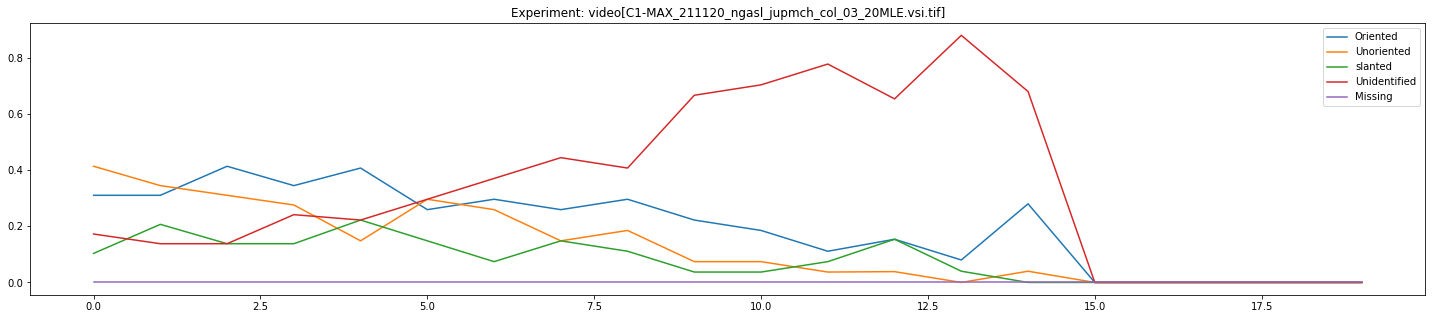

In [50]:
fig, axs = plt.subplots(nrows=len(annotations_by_frame), figsize=(25, 5*len(annotations_by_frame)))

j = 0
for experiment, frames in annotations_by_frame.items():
    num_orienteds = []
    num_unorienteds = []
    num_slanteds = []
    num_unidentifieds = []
    num_missings = []
    for frame, particles in frames.items():

        num_oriented = len([annotation for annotation in particles.values() if annotation['assigned'] == 1])
        num_unoriented = len([annotation for annotation in particles.values() if annotation['assigned'] == 0])
        num_slanted = len([annotation for annotation in particles.values() if annotation['assigned'] == 2])
        num_unidentified = len([annotation for annotation in particles.values() if annotation['assigned'] == 3])
        num_missing = len([annotation for annotation in particles.values() if annotation['assigned'] == 4])

        total = num_oriented + num_unoriented + num_slanted + num_unidentified + num_missing
        if total != 0:

            num_orienteds.append(num_oriented/total)
            num_unorienteds.append(num_unoriented/total)
            num_slanteds.append(num_slanted/total)
            num_unidentifieds.append(num_unidentified/total)
            num_missings.append(num_missing/total)
        
        else:
            num_orienteds.append(0)
            num_unorienteds.append(0)
            num_slanteds.append(0)
            num_unidentifieds.append(0)
            num_missings.append(0)
            

        

    if len(annotations_by_frame) != 1:
        axs[j].set_title(f"Experiment: {experiment}")
        # for key, frame in particle_data.items():
        axs[j].plot(num_orienteds, label="Oriented")
        axs[j].plot(num_unorienteds, label="Unoriented")
        axs[j].plot(num_slanteds, label="slanted")
        axs[j].plot(num_unidentifieds, label="Unidentified")
        axs[j].plot(num_missings, label="Missing")
        axs[j].set_xlabel("")
        axs[j].legend()

    else:
        axs.set_title(f"Experiment: {experiment}")
        # for key, frame in particle_data.items():
        axs.plot(num_orienteds, label="Oriented")
        axs.plot(num_unorienteds, label="Unoriented")
        axs.plot(num_slanteds, label="slanted")
        axs.plot(num_unidentifieds, label="Unidentified")
        axs.plot(num_missings, label="Missing")
        axs.set_xlabel("")
        axs.legend()

    j = j+1

ZeroDivisionError: division by zero

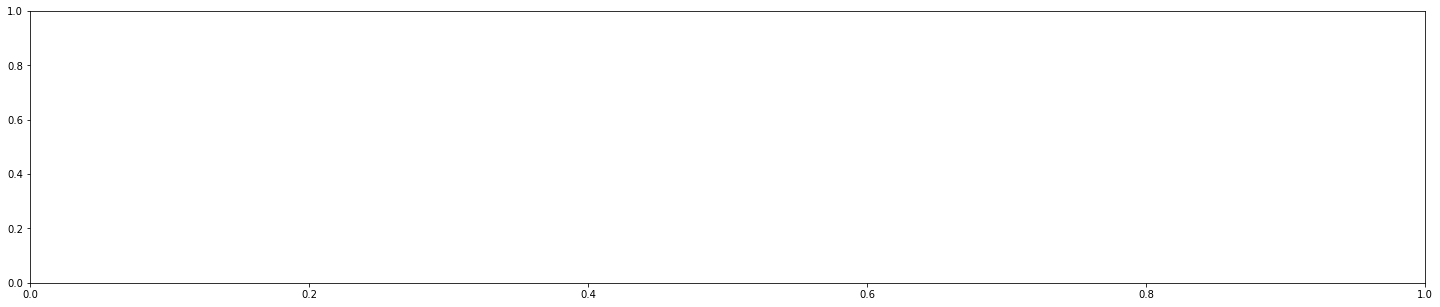

In [51]:
fig, axs = plt.subplots(nrows=len(annotations_by_frame), figsize=(25, 5*len(annotations_by_frame)))

j = 0
for experiment, frames in annotations_by_frame.items():
    num_orienteds = []
    num_unorienteds = []
    num_slanteds = []
    num_unidentifieds = []
    num_missings = []
    num_fractions = []
    for frame, particles in frames.items():

        num_oriented = len([annotation for annotation in particles.values() if annotation['assigned'] == 1])
        num_unoriented = len([annotation for annotation in particles.values() if annotation['assigned'] == 0])
        num_slanted = len([annotation for annotation in particles.values() if annotation['assigned'] == 2])
        num_unidentified = len([annotation for annotation in particles.values() if annotation['assigned'] == 3])
        num_missing = len([annotation for annotation in particles.values() if annotation['assigned'] == 4])

        total = num_oriented + num_unoriented + num_slanted + num_unidentified + num_missing
        
        if total != 0:

            num_orienteds.append(num_oriented/total)
            num_unorienteds.append(num_unoriented/total)
            num_slanteds.append(num_slanted/total)
            num_unidentifieds.append(num_unidentified/total)
            num_missings.append(num_missing/total)
        
        else:
            num_orienteds.append(0)
            num_unorienteds.append(0)
            num_slanteds.append(0)
            num_unidentifieds.append(0)
            num_missings.append(0)

        if num_oriented == 0:
            num_fractions.append(0)
        else:
            num_fractions.append(num_oriented / num_unoriented)


    axs[j].set_title(f"Experiment: {experiment}")
    # for key, frame in particle_data.items():
    axs[j].plot(num_fractions, label="Oriented/unoriented")
    # axs[j].plot(num_unorienteds, label="Unoriented")
    # axs[j].plot(num_slanteds, label="slanted")
    # axs[j].plot(num_unidentifieds, label="Unidentified")
    # axs[j].plot(num_missings, label="Missing")
    axs[j].set_xlabel("Frame")
    axs[j].legend()
    
    j = j+1